## Confirmation required:
Data path,
ROOT path

In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean, stdev
from math import sqrt

import sys
sys.path.append('/home/tajima/software/build_root/lib')
from ROOT import TF2,TF1 ,TGraph2DErrors,TGraph2D,TGraphErrors,TCanvas,TLegend


Welcome to JupyROOT 6.16/00


## Reading Data


In [2]:
class data():
    def __init__(self,pos_num=97):
        self.pos_x = np.ones(pos_num)
        self.pos_y = np.ones(pos_num)
        self.vol_pu = np.power(10.,np.ones((25,pos_num))/20.)

In [3]:
pu_num_table={1:12,2:11,\
              3:10,4:9,\
              5:8,6:7,\
              7:6,8:5,\
              9:4,10:3,\
              11:2,12:1,\
              13:0,14:15,
              15:14,16:13}
### information ###
frequency = ['1700000','3400000','5100000']
path = ['./data_WC_1st/','./data_WC_2nd/']
output = './output_WC/'
dir = [['161014_15913_10','161014_261014_10', '161014_371115_10','161014_481216_10'],
       #['16elec_190826_15913_5','16elec_190826_261014_5', '16elec_190826_171115_5','16elec_190826_481216_5']###373
       ['16elec_190829_15913_10_2','16elec_190829_261014_10', '16elec_190829_371115_10','16elec_190829_481216_10']
      ]
num_dir = [4,4]
j_dic = [{0:2, 1:3, 2:1,3:0 },{0:2, 1:3, 2:1,3:0}]
num_pos = [97 , 97]
path2= './data_WC_2nd/16elec_190823_15913_10/16elec_190823_15913_10' ### 8/23

In [4]:
def read_spar_dat(filename,num_1st_2nd=1):
    list_data = [ data(num_pos[num_1st_2nd-1]) for ch in range(16)]
    for i in range(num_dir[num_1st_2nd-1]):
        for j in range(len(filename)):
            filepath = path[num_1st_2nd-1] + dir[num_1st_2nd-1][i] + '/' + dir[num_1st_2nd-1][i]  + filename[j] +'.dat'
            pu_num = pu_num_table[1 + i  + 4 * j_dic[num_1st_2nd-1][j]]
            f = open(filepath)
            #print(pu_num)
            flag = 0
            for s_line in f:
                split_line = s_line.split()               
                if len(split_line)<3: pass
                elif split_line[0] == 'R(beam)[mm]':
                    list_data[pu_num].pos_x = np.array(split_line[1:], dtype = 'float')
                    position_num = len(split_line[1:])
                elif split_line[0] == 'Y(beam)[mm]':
                    list_data[pu_num].pos_y = np.array(split_line[1:], dtype = 'float')
                elif split_line[0] == 'Frequency':
                    list_data[pu_num].vol_pu[flag] = np.power(10.,np.array(split_line[6:], dtype = 'float')/20.)
                    flag += 1
                elif flag != 0:
                    list_data[pu_num].vol_pu[flag] = np.power(10.,np.array(split_line[1:], dtype = 'float')/20.)
                    flag += 1
            #print('This file contains ',position_num  ,' position data.')
            #print(flag)
    return list_data

In [5]:
filename =[ ['-1of2-s12','-1of2-s32','-1of2-s42','-1of2-s52'],['-2of2-s12','-2of2-s32','-2of2-s42','-2of2-s52'] ] 
list_data =[ read_spar_dat(filename[i]) for i in range(2)]
#print(list_data[0][2].vol_pu[0])
#print(list_data[0][1].vol_pu[0])
filename = [['-(1of2)-s12','-(1of2)-s32','-(1of2)-s42','-(1of2)-s52'],['-(2of2)-s12','-(2of2)-s32','-(2of2)-s42','-(2of2)-s52']]
list_data_2nd =[ read_spar_dat(filename[i],2) for i in range(2)]

In [6]:


###seikika
for f in range(25):
    for i in range(97*2):
        total = 0
        for ch in range(16):
            total += list_data[i//97][ch].vol_pu[f][i%97]
        for ch in range(16):
            list_data[i//97][ch].vol_pu[f][i%97] /= total
        total = 0
        for ch in range(16):
            total += list_data_2nd[i//97][ch].vol_pu[f][i%97]
        for ch in range(16):
            list_data_2nd[i//97][ch].vol_pu[f][i%97] /= total
          

## fitting

In [7]:
def cal_fitting_function(order_num,R):
    x = sym.Symbol('x',real = True)
    y = sym.Symbol('y',real = True)
    I = sym.S.ImaginaryUnit

    for i in range(order_num):
        if i == 0:
            answer = '[0]'
            continue
        elif i == 1:
            answer += '+ x * [1]/R'
            continue
        elif i == 2:
            answer += '+ y * [2]/R'
            continue

        n = int((i-1)/2+1)
        g = int(i%2)
        a = sym.expand((x+I*y)**n).collect(I)
        if g == 1:        ###Q =1. R =82.5 +2.5
            b = sym.re(a)
            answer += '+(' + str(b) + ')*[' + str(i) + ']' + '/R**' + str(n)
        elif g == 0:
            b = sym.im(a)
            answer += '+(' + str(b) + ')*[' + str(i) + ']' + '/R**' + str(n)
    #answer = answer.replace('R', '[16]')
    answer = answer.replace('R', str(R))
    #answer = answer.replace('x', '(x - [16])')
    #answer = answer.replace('y', '(y - [17])')
    return answer
print(cal_fitting_function(16,82.5))

[0]+ x * [1]/82.5+ y * [2]/82.5+(x**2 - y**2)*[3]/82.5**2+(2*x*y)*[4]/82.5**2+(x**3 - 3*x*y**2)*[5]/82.5**3+(3*x**2*y - y**3)*[6]/82.5**3+(x**4 - 6*x**2*y**2 + y**4)*[7]/82.5**4+(4*x**3*y - 4*x*y**3)*[8]/82.5**4+(x**5 - 10*x**3*y**2 + 5*x*y**4)*[9]/82.5**5+(5*x**4*y - 10*x**2*y**3 + y**5)*[10]/82.5**5+(x**6 - 15*x**4*y**2 + 15*x**2*y**4 - y**6)*[11]/82.5**6+(6*x**5*y - 20*x**3*y**3 + 6*x*y**5)*[12]/82.5**6+(x**7 - 21*x**5*y**2 + 35*x**3*y**4 - 7*x*y**6)*[13]/82.5**7+(7*x**6*y - 35*x**4*y**3 + 21*x**2*y**5 - y**7)*[14]/82.5**7+(x**8 - 28*x**6*y**2 + 70*x**4*y**4 - 28*x**2*y**6 + y**8)*[15]/82.5**8


In [8]:
def get_par(ch,fre_num,order_num=16,R=82.5,R_max=55,num_1st_2nd=1):
    par = np.zeros(order_num)
    epar = np.zeros(order_num)
    if num_1st_2nd == 1:
        x = np.hstack((list_data[0][ch].pos_x,list_data[1][ch].pos_x))
        y = np.hstack((list_data[0][ch].pos_y,list_data[1][ch].pos_y))
        vol = np.hstack((list_data[0][ch].vol_pu[fre_num],list_data[1][ch].vol_pu[fre_num]))
    elif num_1st_2nd == 2:
        x = np.hstack((list_data_2nd[0][ch].pos_x,list_data_2nd[1][ch].pos_x))
        y = np.hstack((list_data_2nd[0][ch].pos_y,list_data_2nd[1][ch].pos_y))
        vol = np.hstack((list_data_2nd[0][ch].vol_pu[fre_num],list_data_2nd[1][ch].vol_pu[fre_num]))

    graph = TGraph2D(x.size, x.astype(np.double),y.astype(np.double),vol.astype(np.double))

    fitting_function = cal_fitting_function(order_num,R)
    func =TF2('func',fitting_function,-1*R_max,R_max,-1*R_max,R_max)
    #func.SetParameter(16,82.5)
    fit = graph.Fit('func','RQNS')
    fit = graph.Fit('func', 'RQNS')
    fit = graph.Fit('func', 'RQNS')
    fit = graph.Fit('func', 'RQNS')
    
    #R = func.GetParameter(16)
    for i in range(order_num):
        par[i] = func.GetParameter(i) /  R**((i+1)//2)
        epar[i] = func.GetParError(i) /  R**((i+1)//2)
    chi = func.GetChisquare()
    return par,epar#,chi




In [9]:
## get par
A,eA=get_par(0,3)
A[1:] /=A[0]
eA /=A[0]
B,eB=get_par(0,3,num_1st_2nd=2)
B[1:] /=B[0]
eB /=B[0]
A[0] = 1
B[0] = 1
print(A,B)
print(eA)
print(eB)

[ 1.00000000e+00  2.35333966e-02  9.50564149e-05  2.76218951e-04
  1.33579014e-06  3.23540377e-06  5.99375943e-09  3.81560263e-08
  5.05582844e-11  4.59590367e-10  3.38366607e-13  5.52182918e-12
 -9.55003545e-15  6.95074515e-14 -2.11523750e-16  7.52060070e-16] [ 1.00000000e+00  2.35162370e-02  2.93354769e-05  2.76291819e-04
  2.22193010e-07  3.23538431e-06  7.46989398e-09  3.81615474e-08
  6.72746590e-11  4.59401668e-10  3.31774966e-13  5.49417781e-12
  6.43256928e-15  6.84975686e-14 -6.98799086e-18  7.37946213e-16]
[7.96492910e-04 2.88240487e-05 2.88260797e-05 6.10903374e-07
 6.69993728e-07 1.34329000e-08 1.34343535e-08 2.97873769e-10
 2.41570218e-10 5.41101297e-12 5.41132404e-12 1.09685297e-13
 1.02601387e-13 2.06160987e-15 2.06180758e-15 3.49601472e-17]
[7.60366282e-04 2.75166433e-05 2.75191551e-05 5.83201857e-07
 6.39618263e-07 1.28237676e-08 1.28254752e-08 2.84372321e-10
 2.30618284e-10 5.16577655e-12 5.16600435e-12 1.04712059e-13
 9.79531482e-14 1.96820009e-15 1.96834527e-15 3.33

In [10]:
def get_matrix(order_num,fre_num,R=82.5,R_max=55,ch=range(16),num_1st_2nd=1):

    A = np.empty((0,order_num),float)
    eA = np.empty((0,order_num),float)
    for i in ch:
        par,epar = get_par(i,fre_num,order_num,R,R_max,num_1st_2nd=num_1st_2nd)
        A = np.append(A,[par],axis = 0)
        eA = np.append(eA,[epar],axis = 0)
    inv_A = np.linalg.pinv(A)
    return A,eA,inv_A
#test= get_matrix(16,1,ch=range(4))
#print(test[0])
#test= get_matrix(16,1,ch=range(4),num_1st_2nd=2)
#print(test[0])


In [49]:
### save matrix
boke = {1:"_1-7MHz",3:"_3-4MHz",5:"_5-1MHz"}
hoge = {1:"_1st.txt",2:"_2nd.txt"}
for i in [1,2]:
    for j in [1,3,5]:
        A = get_matrix(16,j,ch=range(16),num_1st_2nd=i)
        np.savetxt(output+'invA'+boke[j]+hoge[i],A[2])
        A = get_matrix(16,j,ch=range(0,16,2),num_1st_2nd=i)
        np.savetxt(output+'invA_8pu_0'+boke[j]+hoge[i],A[2])
        A = get_matrix(16,j,ch=range(1,16,2),num_1st_2nd=i)
        np.savetxt(output+'invA_8pu_1'+boke[j]+hoge[i],A[2])


### backup

In [11]:
### compare 1st and 2nd
fre = 3
#ch_list = [0,4,8,12,3,7,11,15,2,6,10,14]
#ch_list = [3,7,11,15]
#ch_list = [0,3,4,7,8,11,12,15]
ch_list = range(16)

A_1st = get_matrix(18,3,ch=ch_list)
A_2nd = get_matrix(18,3,ch=ch_list,num_1st_2nd=2)

pos_1st = np.array([ [ list_data[n//97][0].pos_x[n%97],list_data[n//97][0].pos_y[n%97]] for n in range(97*2)] )
pos_2nd = np.array([ [ list_data_2nd[n//num_pos[1]][0].pos_x[n%num_pos[1]],list_data_2nd[n//num_pos[1]][0].pos_y[n%num_pos[1]]] for n in range(num_pos[1]*2)] )

vol_1st = np.array([ [ list_data[n//97][ch].vol_pu[fre][n%97] for ch in ch_list ] for n in range(97*2) ])
vol_2nd = np.array([ [ list_data_2nd[n//num_pos[1]][ch].vol_pu[fre][n%num_pos[1]] for ch in ch_list ] for n in range(num_pos[1]*2) ])
#mom_1st = np.array([ np.dot(A_1st[2],vol_1st[i]/np.sum(vol_1st[i])) for i in range(97*2)])
#mom_2nd = np.array([ np.dot(A_2nd[2],vol_2nd[i]/np.sum(vol_2nd[i])) for i in range(num_pos[1]*2)])
mom_1st = np.array([ np.dot(A_1st[2],vol_1st[i]) for i in range(97*2)])
mom_2nd = np.array([ np.dot(A_2nd[2],vol_2nd[i]) for i in range(num_pos[1]*2)])
mom_1st[:,1] = mom_1st[:,1]/mom_1st[:,0] - pos_1st[:,0]
mom_2nd[:,1] = mom_2nd[:,1]/mom_2nd[:,0] - pos_2nd[:,0]
mom_1st[:,2] = mom_1st[:,2]/mom_1st[:,0] - pos_1st[:,1]
mom_2nd[:,2] = mom_2nd[:,2]/mom_2nd[:,0] - pos_2nd[:,1]
mom_1st[:,3] = mom_1st[:,3]/mom_1st[:,0] - pos_1st[:,0]**2 + pos_1st[:,1]**2
mom_2nd[:,3] = mom_2nd[:,3]/mom_2nd[:,0] - pos_2nd[:,0]**2 + pos_2nd[:,1]**2




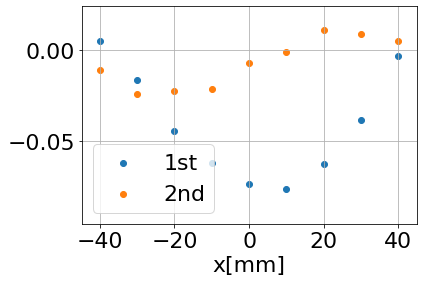

In [31]:
mom = 2
a = 44
b = 53
plt.scatter(pos_1st[a:b,0],mom_1st[a:b,mom],label='1st')
#a = 178#+373
#b = 195#+373
plt.scatter(pos_2nd[a:b,0],mom_2nd[a:b,mom],label='2nd')
plt.grid()
plt.xlabel('x[mm]')
#plt.ylabel('$\Delta y[\mathrm{mm}]$')
#plt.ylabel('$\Delta x^2-y^2[\mathrm{mm^2}]$')
plt.legend()
plt.savefig('test.pdf')

In [12]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
def a(x):
    return Decimal(str(np.abs(x))).quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)
def b(x):
    return Decimal(str(np.abs(1000*x))).quantize(Decimal('1'), rounding=ROUND_HALF_UP)

<Figure size 432x288 with 0 Axes>

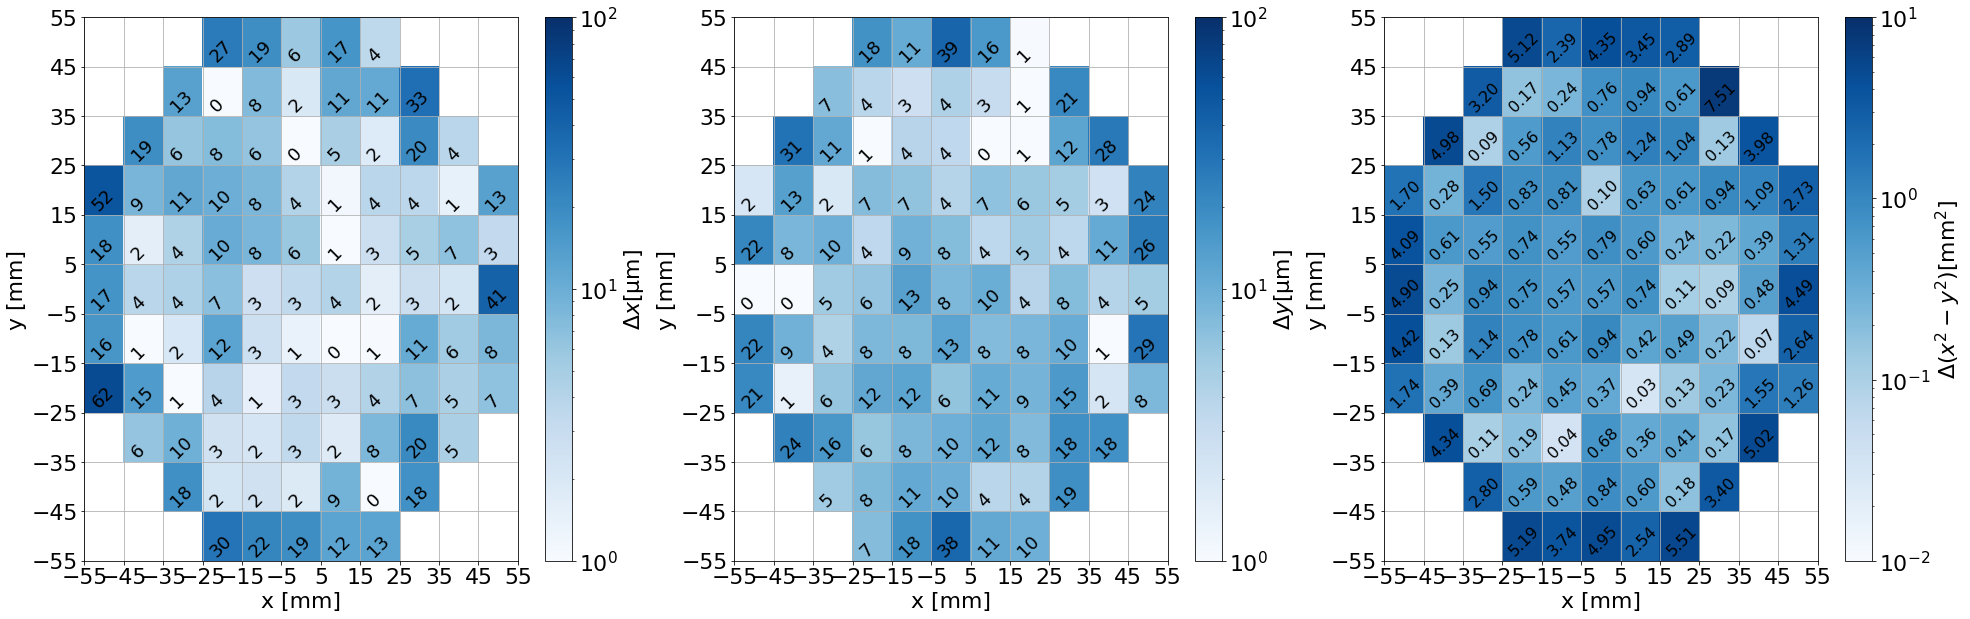

In [37]:
### master
from matplotlib.colors import LogNorm
plt.subplots_adjust(left=0.05,right=0.95,bottom=0.05,top=0.95)
plt.rcParams["font.size"] = 22

fig =plt.figure(figsize=(33,10))
plt.subplot(1,3,3)
H,xedges, yedges, img = plt.hist2d(pos_1st[0:97,0], pos_1st[0:97,1],bins=np.linspace(-55, 55, 12), norm=LogNorm(),cmap='Blues',weights=np.abs(mom_2nd[0:97,3]))
for i in range(97):
    plt.text(pos_1st[i,0]-4,pos_1st[i,1]-4,a(mom_2nd[i,3]), size = 16,rotation=45)
cbar= fig.colorbar(img)#,ax=ax)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
img.set_clim(1e-2,10)
cbar.set_label('$\Delta (x^2-y^2)[\mathrm{mm^2}]$')
plt.xticks(xedges)
plt.yticks(yedges)
plt.grid()

plt.subplot(1,3,1)
H,xedges, yedges, img = plt.hist2d(pos_1st[0:97,0], pos_1st[0:97,1],bins=np.linspace(-55, 55, 12), norm=LogNorm(),cmap='Blues',weights=1000*np.abs(mom_2nd[0:97,1]))
cbar= fig.colorbar(img)#,ax=ax)
for i in range(97):
    plt.text(pos_1st[i,0]-4,pos_1st[i,1]-4,b(mom_2nd[i,1]), size = 18,rotation=45)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
img.set_clim(1,100)
cbar.set_label('$\Delta x[\mathrm{\mu m}]$')
plt.xticks(xedges)
plt.yticks(yedges)
plt.grid()

plt.subplot(1,3,2)
H,xedges, yedges, img = plt.hist2d(pos_1st[0:97,0], pos_1st[0:97,1],bins=np.linspace(-55, 55, 12), norm=LogNorm(),cmap='Blues',weights=1000*np.abs(mom_2nd[0:97,2]))
cbar= fig.colorbar(img)#,ax=ax)
for i in range(97):
    plt.text(pos_1st[i,0]-4,pos_1st[i,1]-4,b(mom_2nd[i,2]), size = 18,rotation=45)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
img.set_clim(1,100)
cbar.set_label('$\Delta y[\mathrm{\mu m}]$')
plt.xticks(xedges)
plt.yticks(yedges)
plt.grid()
plt.savefig('wc_error_13.pdf')

<Figure size 432x288 with 0 Axes>

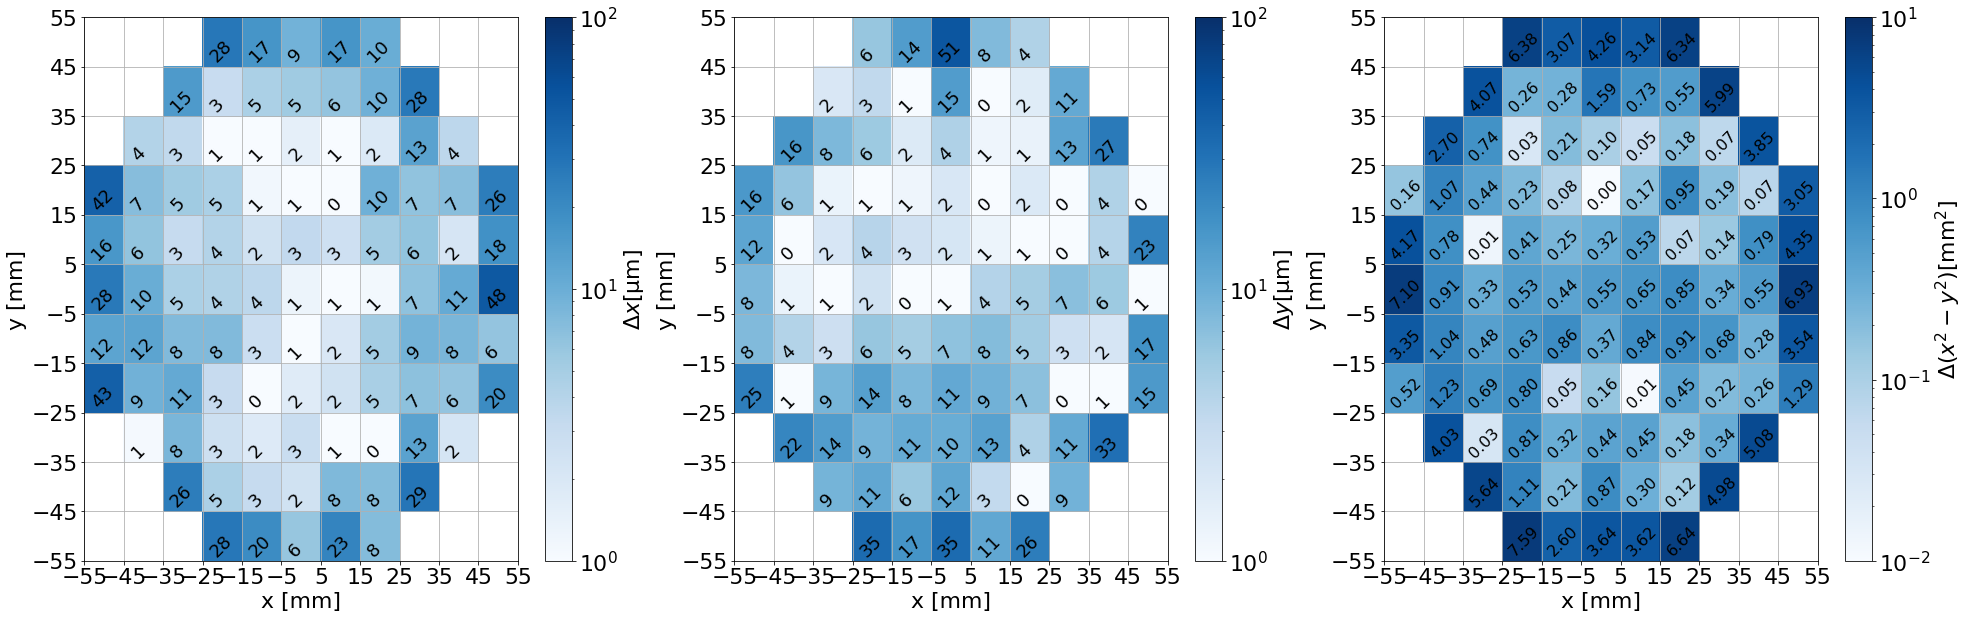

In [38]:
### master
from matplotlib.colors import LogNorm
plt.subplots_adjust(left=0.05,right=0.95,bottom=0.05,top=0.95)
plt.rcParams["font.size"] = 22

fig =plt.figure(figsize=(33,10))
plt.subplot(1,3,3)
H,xedges, yedges, img = plt.hist2d(pos_1st[0:97,0], pos_1st[0:97,1],bins=np.linspace(-55, 55, 12), norm=LogNorm(),cmap='Blues',weights=np.abs(mom_1st[0:97,3]))
for i in range(97):
    plt.text(pos_1st[i,0]-4,pos_1st[i,1]-4,a(mom_1st[i,3]), size = 16,rotation=45)
cbar= fig.colorbar(img)#,ax=ax)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
img.set_clim(1e-2,10)
cbar.set_label('$\Delta (x^2-y^2)[\mathrm{mm^2}]$')
plt.xticks(xedges)
plt.yticks(yedges)
plt.grid()

plt.subplot(1,3,1)
H,xedges, yedges, img = plt.hist2d(pos_1st[0:97,0], pos_1st[0:97,1],bins=np.linspace(-55, 55, 12), norm=LogNorm(),cmap='Blues',weights=1000*np.abs(mom_1st[0:97,1]))
cbar= fig.colorbar(img)#,ax=ax)
for i in range(97):
    plt.text(pos_1st[i,0]-4,pos_1st[i,1]-4,b(mom_1st[i,1]), size = 18,rotation=45)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
img.set_clim(1,100)
cbar.set_label('$\Delta x[\mathrm{\mu m}]$')
plt.xticks(xedges)
plt.yticks(yedges)
plt.grid()

plt.subplot(1,3,2)
H,xedges, yedges, img = plt.hist2d(pos_1st[0:97,0], pos_1st[0:97,1],bins=np.linspace(-55, 55, 12), norm=LogNorm(),cmap='Blues',weights=1000*np.abs(mom_1st[0:97,2]))
cbar= fig.colorbar(img)#,ax=ax)
for i in range(97):
    plt.text(pos_1st[i,0]-4,pos_1st[i,1]-4,b(mom_1st[i,2]), size = 18,rotation=45)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
img.set_clim(1,100)
cbar.set_label('$\Delta y[\mathrm{\mu m}]$')
plt.xticks(xedges)
plt.yticks(yedges)
plt.grid()
plt.savefig('wc_error_15.pdf')

In [26]:
max_2nd = [[],[],[]]
R =35
for i in range(97*2):
    if pos_2nd[i][0]**2 + pos_2nd[i][1]**2 < R**2: 
        #print(i)
        max_2nd[0].append(np.abs(mom_2nd[i][1]))
        max_2nd[1].append(np.abs(mom_2nd[i][2]))
        max_2nd[2].append(np.abs(mom_2nd[i][3]))
max_1st = [[],[],[]]
for i in range(97*2):
    if pos_1st[i][0]**2 + pos_1st[i][1]**2 < R**2: 
        #print(i)
        max_1st[0].append(np.abs(mom_1st[i][1]))
        max_1st[1].append(np.abs(mom_1st[i][2]))
        max_1st[2].append(np.abs(mom_1st[i][3]))
            
   
[ print(np.mean(max_1st[i]),np.std(max_1st[i])) for i in range(3)]
[ print(np.mean(max_2nd[i]),np.std(max_2nd[i])) for i in range(3)]


0.0027493984320672922 0.0019410962148238718
0.004486406961098838 0.0038671834466778685
0.40162479257950523 0.26344384654856295
0.003991351788369526 0.0025227486779852925
0.006929221464304777 0.003273271556214308
0.5373311445558476 0.3039373577683265


[None, None, None]

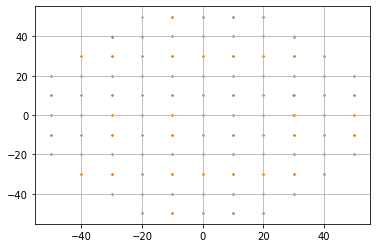

In [16]:
#a = 176
#b = 197
a = 0
b = -1
#plt.scatter(pos_2nd[a:b,0],pos_2nd[a:b,1],s=1)
plt.scatter(mom_2nd[a:b,1]+pos_2nd[a:b,0],mom_2nd[a:b,2]+pos_2nd[a:b,1],s =1)
plt.scatter(mom_1st[a:b,1]+pos_1st[a:b,0],mom_1st[a:b,2]+pos_1st[a:b,1],s =1)
plt.grid()

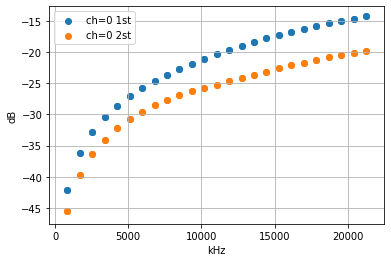

In [17]:
### compare 1st and 2nd(8/23)
ch = 0
ob_fre = [850 + 850*(i%25) for i in range(50)]
s_par_1st =  np.array([ 20 *np.log10(list_data[n//25][ch].vol_pu[n%25][48]) for n in range(25*2)] )
s_par_2nd =  np.array([ 20 *np.log10(list_data_2nd[n//25][ch].vol_pu[n%25][48]) for n in range(25*2)] ) #190

plt.scatter(ob_fre,s_par_1st,label='ch='+str(ch)+' 1st')
plt.scatter(ob_fre,s_par_2nd,label='ch='+str(ch)+' 2st')
plt.xlabel('kHz')
plt.ylabel('dB')
plt.grid()
plt.legend()
plt.savefig('test.pdf')



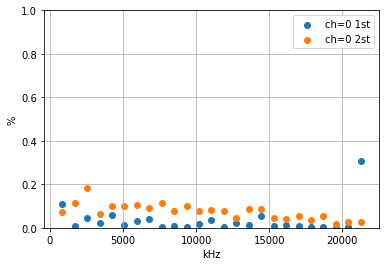

In [18]:
### compare 1st and 2nd(8/23)
ch = 0
pos = 0
ob_fre = [850 + 850*(i%25) for i in range(25)]
err_1st =  100*np.array([ abs(list_data[0][ch].vol_pu[n%25][pos] -list_data[1][ch].vol_pu[n%25][pos])/(list_data[0][ch].vol_pu[n%25][pos] +list_data[1][ch].vol_pu[n%25][pos])*2  for n in range(25)] )
err_2nd =  100*np.array([ abs(list_data_2nd[0][ch].vol_pu[n%25][pos] -list_data_2nd[1][ch].vol_pu[n%25][pos])/(list_data_2nd[0][ch].vol_pu[n%25][pos] +list_data_2nd[1][ch].vol_pu[n%25][pos])*2  for n in range(25)] )

plt.scatter(ob_fre,err_1st,label='ch='+str(ch)+' 1st')
plt.scatter(ob_fre,err_2nd,label='ch='+str(ch)+' 2st')
plt.xlabel('kHz')
plt.ylabel('%')
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.savefig('test.pdf')


In [19]:
ch = 0
num = 0
for pos in range(97):
    err_2nd =  100*np.array([ abs(list_data_2nd[0][ch].vol_pu[n%25][pos] -list_data_2nd[1][ch].vol_pu[n%25][pos])/(list_data_2nd[0][ch].vol_pu[n%25][pos] +list_data_2nd[1][ch].vol_pu[n%25][pos])*2  for n in range(25)] )
    if np.max(err_2nd[3]) > 0.01:
        print(pos,' ',np.max(err_2nd[3]))
        num += 1
print(num)
for pos in range(97):
    err_1st =  100*np.array([ abs(list_data[0][ch].vol_pu[n%25][pos] -list_data[1][ch].vol_pu[n%25][pos])/(list_data[0][ch].vol_pu[n%25][pos] +list_data[1][ch].vol_pu[n%25][pos])*2  for n in range(25)] )
    if np.max(err_1st[3]) > 0.2:
        print(pos,' ',np.max(err_1st[3]))
        num += 1
print(num)


0   0.06400944568538951
1   0.15016639736932125
3   0.021770136063433466
4   0.02778667568940652
5   0.027004832935790462
7   0.010801426660742268
8   0.06370573474260983
9   0.08762751807958317
10   0.023459657853919035
11   0.1955238357524731
12   0.011612857644979822
13   0.015838446658279392
15   0.06519493149678697
16   0.1461812004071519
17   0.05057190557816614
18   0.06140418603800044
19   0.24142880796196378
20   0.3026324421914975
21   0.03965143581588643
22   0.01241116389377613
23   0.016702606837977346
24   0.02565793580901594
25   0.2224775219880453
26   0.13340059296740792
27   0.21658820719204622
28   0.041173905017207295
29   0.32283285667482414
30   0.3383849344050731
31   0.15624694538503386
32   0.08307300559530482
33   0.20820266225877684
34   0.04264157269105419
35   0.023667005638590557
36   0.031502242043031876
37   0.013586633578795224
38   0.011150383430514388
40   0.11848583420729789
41   0.013969438348654144
42   0.05570045299348571
43   0.022805723696238803

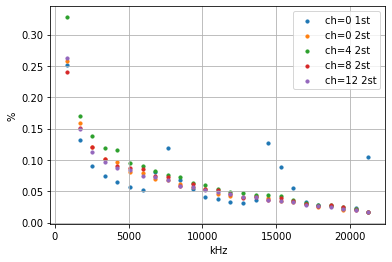

In [20]:
### compare 1st and 2nd(8/23)
fre_num = 3
ob_fre = [850 + 850*(i%25) for i in range(25)]
def err_all_pos(fre_num):
    err_1st =  [ np.mean(100*np.array([ abs(list_data[0][i].vol_pu[fre_num][pos] -list_data[1][i].vol_pu[fre_num][pos])/(list_data[0][i].vol_pu[fre_num][pos] +list_data[1][i].vol_pu[fre_num][pos])*2  for pos in range(97)] )) for i in range(16) ]
    err_2nd =  [ np.mean(100*np.array([ abs(list_data_2nd[0][i].vol_pu[fre_num][pos] -list_data_2nd[1][i].vol_pu[fre_num][pos])/(list_data_2nd[0][i].vol_pu[fre_num][pos] +list_data_2nd[1][i].vol_pu[fre_num][pos])*2  for pos in range(num_pos[1])] )) for i in range(16)]
    return [err_1st,err_2nd]

err = np.array([ err_all_pos(i) for i in range(25)])

plt.scatter(ob_fre,err[:,0,0],s=10,label='ch='+str(0)+' 1st')
'''
plt.scatter(ob_fre,err[:,0,1],s=10,label='ch='+str(4)+' 1st')
plt.scatter(ob_fre,err[:,0,2],s=10,label='ch='+str(8)+' 1st')
plt.scatter(ob_fre,err[:,0,3],s=10,label='ch='+str(12)+' 1st')
'''

plt.scatter(ob_fre,err[:,1,0],s=10,label='ch='+str(0)+' 2st')
plt.scatter(ob_fre,err[:,1,4],s=10,label='ch='+str(4)+' 2st')
plt.scatter(ob_fre,err[:,1,8],s=10,label='ch='+str(8)+' 2st')
plt.scatter(ob_fre,err[:,1,12],s=10,label='ch='+str(12)+' 2st')

plt.xlabel('kHz')
plt.ylabel('%')
plt.grid()
plt.legend()
plt.savefig('test11.pdf')


In [21]:
data = np.array([ [ list_data[n//97][0].pos_x[n%97],list_data[n//97][0].pos_y[n%97]] for n in range(97*2)] )
def cal_mom(order_num,fre_num,R=82.5,R_max=55):
    a,b,inv_A = get_matrix(order_num,fre_num,R,R_max)
    a,b,inv_A_8 = get_matrix(order_num,fre_num,R,R_max,ch=range(0,16,2))
    a,b,inv_A_8_1 = get_matrix(order_num,fre_num,R,R_max,ch=range(1,16,2))
    
    moment = []
    moment_8 = []
    moment_8_1 = []

    vol_16 = np.zeros(16)
    vol_8 = np.zeros(8)
    vol_8_1 = np.zeros(8)
    for n in range(97*2):
        for j in range(16):
            vol_16[j] = list_data[n//97][j].vol_pu[3][n%97]
        for j in range(8):
            vol_8[j] = list_data[n//97][2*j].vol_pu[3][n%97]
            vol_8_1[j] = list_data[n//97][2*j+1].vol_pu[3][n%97]

        mom = np.dot(inv_A,vol_16)
        mom_8 = np.dot(inv_A_8,vol_8)
        mom_8_1 = np.dot(inv_A_8_1,vol_8_1)

        buf = mom[0]
        buf_8 = mom_8[0]
        buf_8_1 = mom_8_1[0]


        for i in range(7):
            mom_8[i+1] = mom_8[i+1]/buf_8
            mom_8_1[i+1] = mom_8_1[i+1]/buf_8_1
            mom[i+1] /= buf

        moment.append(mom)
        moment_8.append(mom_8)
        moment_8_1.append(mom_8_1)


    moment_8 = np.array(moment_8)
    moment_8_1 = np.array(moment_8_1)
    moment = np.array(moment)
    return moment,moment_8,moment_8_1
moment,moment_8,moment_8_1 = cal_mom(16,3)

In [22]:
def cal_diff(order_num,fre_num,R=82.5,R_max=55,xy = 0,mom_num=1):
    mo,mo8,mo8_1 = cal_mom(order_num,fre_num,R,R_max)
    x=[]
    diff=[]
    diff_8=[]
    diff_8_1=[]
    for n in range(97*2):
        if abs(data[n][(xy+1)%2]) < 5:
            x.append(data[n][xy])
            if mom_num == 3: buf = data[n][0]**2 - data[n][1]**2
            else: buf = data[n][mom_num-1]
            diff.append(mo[n][mom_num] - buf )
            diff_8.append(mo8[n][mom_num] - buf )
            diff_8_1.append(mo8_1[n][mom_num] - buf )
    plt.scatter(x,  diff, s=0.5,  alpha=1, linewidths="5",label='16pu_'+str(order_num)+'_'+str(R))
    #plt.scatter(x,  diff_8, s=0.5, linewidths="5",label='8pu '+str(order_num))
    #plt.scatter(x,  diff_8_1, s=0.5, c="red", alpha=0.5, linewidths="5",label='8pu 1'+str(order_num))
    plt.grid()
    plt.legend()
    plt.tight_layout()


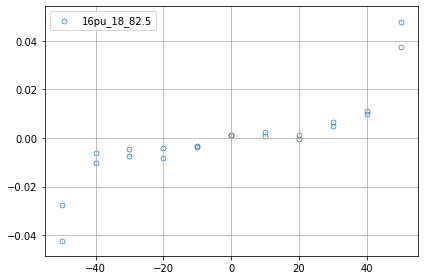

In [23]:
### r_max
cal_diff(18,3,R_max=55,mom_num =1)
#cal_diff(8,3,R_max=35,mom_num=1)
#cal_diff(16,3,R_max=55,mom_num =1)
#cal_diff(16,3,R_max=45,mom_num=1)

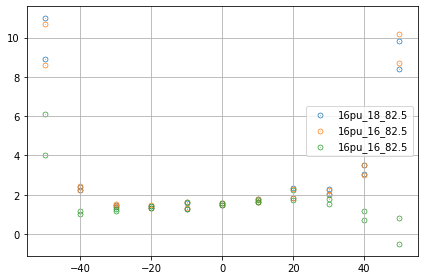

In [24]:
### r_max
cal_diff(18,1,R_max=55,mom_num =3)
#cal_diff(8,3,R_max=35,mom_num=1)
cal_diff(16,1,R_max=55,mom_num =3)
cal_diff(16,1,R_max=45,mom_num=3)

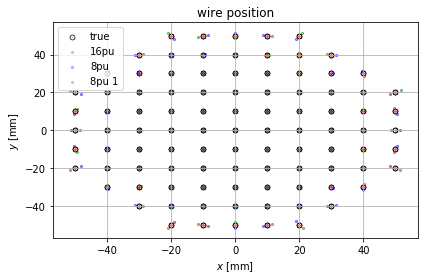

In [25]:
#plt.figure(figsize=(4, 4), dpi=40)

plt.scatter(data[:,0], data[:,1], s=0.5, c="red", alpha=1, linewidths="5",edgecolors="black",label='true')
plt.scatter(moment[:,1], moment[:,2], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="red",label='16pu')
plt.scatter(moment_8[:,1], moment_8[:,2], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="blue",label='8pu')
plt.scatter(moment_8_1[:,1], moment_8_1[:,2], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="green",label='8pu 1')
plt.grid()
plt.title('wire position')
plt.xlabel('$x$ [mm]')
plt.ylabel('$y$ [mm]')
#plt.xlim(-60,60)
#plt.ylim(-60,60)
plt.legend()
plt.tight_layout()
plt.savefig(output+'pos_2d.pdf')
plt.savefig(output+'pos_2d.png')


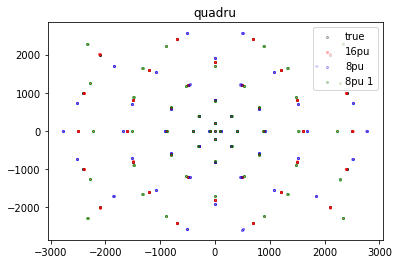

In [26]:
plt.scatter(data[:,0]**2-data[:,1]**2,2*data[:,0]* data[:,1], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="black",label='true')
plt.scatter(moment[:,3], moment[:,4] , s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="red",label='16pu')
plt.scatter(moment_8[:,3], moment_8[:,4] , s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="blue",label='8pu')
plt.scatter(moment_8_1[:,3], moment_8_1[:,4], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="green",label='8pu 1')
#plt.grid()
plt.title('quadru')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.savefig(output+'quadru_2d.pdf')


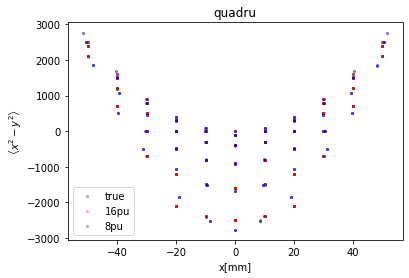

In [27]:
plt.scatter(data[:,0],data[:,0]**2-data[:,1]**2, s=0.5, c="black", alpha=0.5, linewidths="2",edgecolors="black",label='true')
plt.scatter(moment[:,1], moment[:,3] , s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="red",label='16pu')
plt.scatter(moment_8[:,1], moment_8[:,3] , s=0.5, c="blue", alpha=0.5, linewidths="2",edgecolors="blue",label='8pu')
#plt.scatter(moment_8[:,1], moment_8[:,2], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="blue",label='8pu')
#plt.scatter(moment_8_1[:,1], moment_8_1[:,2], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="green",label='8pu 1')
#plt.grid()
plt.title('quadru')
plt.xlabel('x[mm]')
plt.ylabel(r'$\left<x^2-y^2\right>$')
plt.legend()
plt.savefig(output+'quadru_pos_2d.pdf')
plt.savefig(output+'quadru_pos_2d.png')

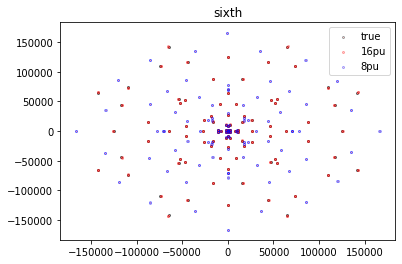

In [28]:
plt.scatter(data[:,0]**3-3*data[:,0]*data[:,1]**2,3*data[:,0]**2* data[:,1] - data[:,1]**3, s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="black",label='true')
plt.scatter(moment[:,5], moment[:,6] , s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="red",label='16pu')
plt.scatter(moment_8[:,5], moment_8[:,6] , s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="blue",label='8pu')
#plt.scatter(moment_8[:,1], moment_8[:,2], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="blue",label='8pu')
#plt.scatter(moment_8_1[:,1], moment_8_1[:,2], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="green",label='8pu 1')
#plt.grid()
plt.title('sixth')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.savefig(output+'./m6_2d.pdf')

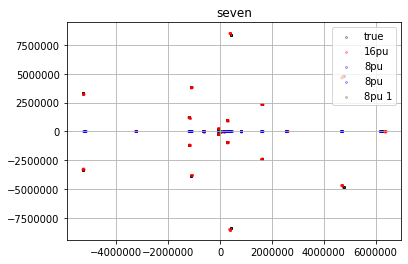

In [29]:
plt.scatter(data[:,0]**4-6*data[:,0]**2*data[:,1]**2+data[:,1]**4, 4*data[:,0]* data[:,1]**3 -4* data[:,1]*data[:,0]**3, s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="black",label='true')
plt.scatter(moment[:,7], moment[:,8] , s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="red",label='16pu')
plt.scatter(moment_8[:,7], np.zeros(97*2) , s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="blue",label='8pu')
plt.scatter(moment_8[:,1], moment_8[:,2], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="blue",label='8pu')
plt.scatter(moment_8_1[:,1], moment_8_1[:,2], s=0.5, c="red", alpha=0.5, linewidths="2",edgecolors="green",label='8pu 1')
plt.grid()
plt.title('seven')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.savefig(output+'./m7_2d.pdf')

In [30]:
def cal_product(fre_num):
    par_name=['1700','3400','5100']
    ifile = output+'A_'+ par_name[fre_num] +'kHz.txt'
    A = np.loadtxt(ifile,delimiter=', ')
    ifile = output+'inv_A_'+ par_name[fre_num] +'kHz.txt'
    inv_A = np.loadtxt(ifile,delimiter=', ')
    [print(np.dot(A,inv_A)[i][i]) for i in range(16)]
cal_product(0)

0.9999999999999999
1.0000000000000002
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999998
1.0
1.0
1.0000000000000002
1.0
1.0
1.0
1.0
0.9999999999999998


In [15]:
aa =['1st','2nd']
def fit_function(order_num,fre_num=3,num_1st_2nd=1):

    ch_c =  np.zeros(16)
    ch_e =  np.zeros(16)
    par =  np.empty(16)
    par_e =  np.empty(16)

    math_func ={0:'[0]',\
            1:'[0]*cos(TMath::Pi()*x/8 )',2:'[0]*sin(TMath::Pi()*x/8 )',\
            3:'[0]*cos(TMath::Pi()*2*x/8 )',4:'[0]*sin(TMath::Pi()*2*x/8 )',\
            5:'[0]*cos(TMath::Pi()*3*x/8 )',6:'[0]*sin(TMath::Pi()*3*x/8 )',\
            7:'[0]*cos(TMath::Pi()*4*x/8 )',8:'[0]*sin(TMath::Pi()*4*x/8 )',\
            9:'[0]*cos(TMath::Pi()*5*x/8 )',10:'[0]*sin(TMath::Pi()*5*x/8 )',\
            11:'[0]*cos(TMath::Pi()*6*x/8 )',12:'[0]*sin(TMath::Pi()*6*x/8 )',\
            13:'[0]*cos(TMath::Pi()*7*x/8 )',14:'[0]*sin(TMath::Pi()*7*x/8 )',\
                15:'[0]*cos(TMath::Pi()*x)',16:'[0]*sin(TMath::Pi()*x)',
                17:'[0]*cos(TMath::Pi()*9*x/8)',18:'[0]*sin(TMath::Pi()*9*x/8)',
                19:'[0]*cos(TMath::Pi()*10*x/8)',20:'[0]*sin(TMath::Pi()*10*x/8)'}
    A,eA,inv_A = get_matrix(order_num,fre_num,R=82.5,R_max=55,ch=range(16),num_1st_2nd=num_1st_2nd)
    for i in range(order_num):
        for ch in range(16):
            ch_c[ch] = ch
            par[ch] = A[ch][i]
            par_e[ch] = eA[ch][i]
        canvas = TCanvas()
        graph = TGraphErrors(16,ch_c.astype(np.double),par.astype(np.double),ch_e.astype(np.double),par_e.astype(np.double))
        func = TF1('func',math_func[i],-1,16)
        graph.SetNameTitle (math_func[i], math_func[i])
        graph.GetXaxis().SetRangeUser(-1.,16);
        graph.Fit('func')
        graph.Draw("AP")
        name = output+'matrix' + str(i)+'of' +str(order_num) + '_'+str(850+850*fre_num)+'kHz_fit_'+str(aa[num_1st_2nd-1])+'.png'
        canvas.SaveAs(name)

    return 1
fit_function(16)
fit_function(16,num_1st_2nd=2)

1

 FCN=4482.52 FROM MIGRAD    STATUS=CONVERGED      14 CALLS          15 TOTAL
                     EDM=6.56652e-25    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.90042e-02   5.60015e-06   3.00000e-04   2.04636e-07
 FCN=774.715 FROM MIGRAD    STATUS=CONVERGED      14 CALLS          15 TOTAL
                     EDM=1.39186e-23    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.87390e-04   2.89285e-07   3.00000e-04   1.82384e-05
 FCN=1047.9 FROM MIGRAD    STATUS=CONVERGED      16 CALLS          17 TOTAL
                     EDM=1.86574e-20    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE 

Info in <TCanvas::Print>: png file ./output_WC/matrix0of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./output_WC/matrix1of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./output_WC/matrix2of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./output_WC/matrix3of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./output_WC/matrix4of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./output_WC/matrix5of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./output_WC/matrix6of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./output_WC/matrix7of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./output_WC/matrix8of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./output_WC/matrix9of16_3400kHz_fit_1st.png has been created
Info in <TCanvas::Print>: png file ./out

In [12]:
### master
order_num=16
fre_num=3
A,eA,inv_A = get_matrix(order_num,fre_num,R=82.5,R_max=55,ch=range(16),num_1st_2nd=1)
B,eB,inv_B = get_matrix(order_num,fre_num,R=82.5,R_max=55,ch=range(16),num_1st_2nd=2)

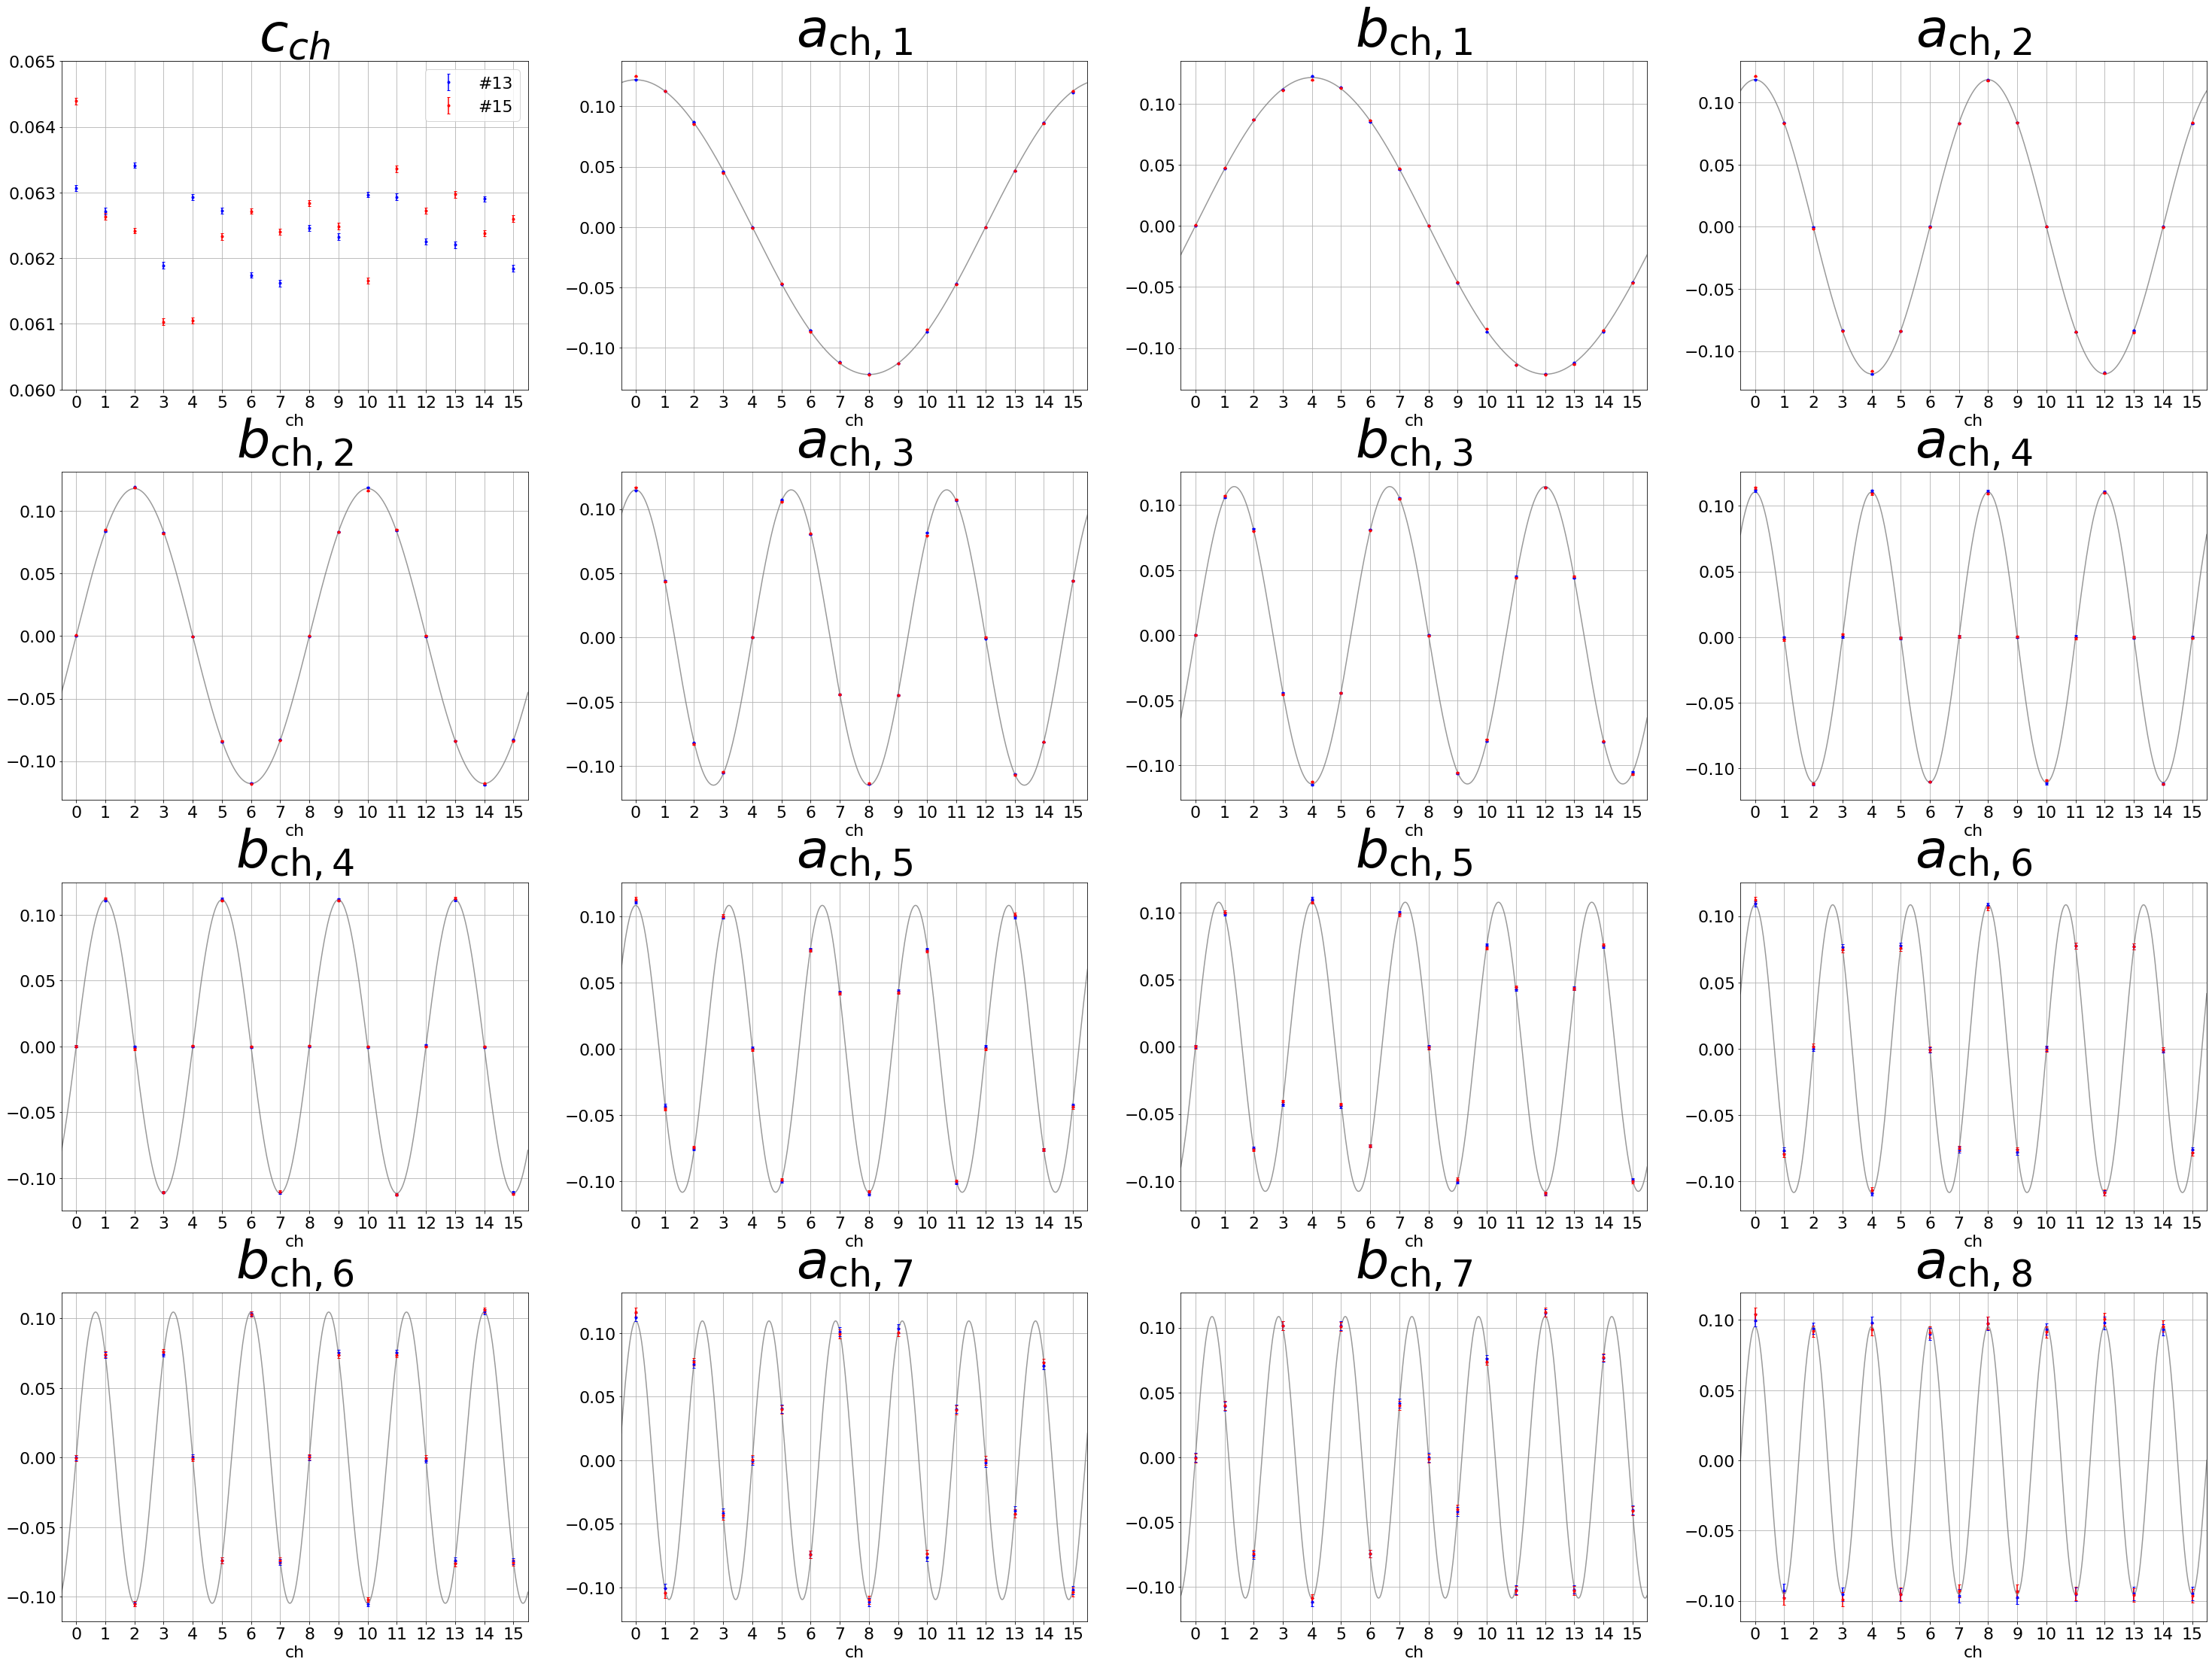

In [23]:
### master
R = 82.5
def cal(a,order_num):
    x = np.linspace(-0.5,15.5,1000)
    n = (order_num +1)//2
    if order_num % 2 == 0:
        return a * np.sin(n*np.pi*x/8),'$b_{\mathrm{ch},'+str(n)+'}$'
    else:
        return a * np.cos(n*np.pi*x/8),'$a_{\mathrm{ch},'+str(n)+'}$'
    
def fit_function():
    plt.figure(figsize=(44, 32))
    plt.subplots_adjust(left=0.05,right=0.95,bottom=0.05,top=0.95,hspace=0.25)
    plt.rcParams["font.size"] = 22
    
    x = np.linspace(-0.5,15.5,1000)
    ch_c =  np.zeros(16)
    ch_e =  np.zeros(16)
    par =  np.empty(16)
    par_e =  np.empty(16)
    par1 =  np.empty(16)
    par1_e =  np.empty(16)
    math_func ={0:'[0]',\
            1:'[0]*cos(TMath::Pi()*x/8 )',2:'[0]*sin(TMath::Pi()*x/8 )',\
            3:'[0]*cos(TMath::Pi()*2*x/8 )',4:'[0]*sin(TMath::Pi()*2*x/8 )',\
            5:'[0]*cos(TMath::Pi()*3*x/8 )',6:'[0]*sin(TMath::Pi()*3*x/8 )',\
            7:'[0]*cos(TMath::Pi()*4*x/8 )',8:'[0]*sin(TMath::Pi()*4*x/8 )',\
            9:'[0]*cos(TMath::Pi()*5*x/8 )',10:'[0]*sin(TMath::Pi()*5*x/8 )',\
            11:'[0]*cos(TMath::Pi()*6*x/8 )',12:'[0]*sin(TMath::Pi()*6*x/8 )',\
            13:'[0]*cos(TMath::Pi()*7*x/8 )',14:'[0]*sin(TMath::Pi()*7*x/8 )',\
            15:'[0]*cos(TMath::Pi()*x)',16:'[0]*sin(TMath::Pi()*x)'}
    
    for i in range(16):#range(1):#order_num):
        plt.subplot(4,4,i+1)
        for ch in range(16):
            n = (i +1)//2
            ch_c[ch] = float(ch)
            par[ch] = A[ch][i] * R**n
            par_e[ch] = eA[ch][i] * R**n
            par1[ch] = B[ch][i]* R**n
            par1_e[ch] = eB[ch][i]* R**n
        if i != 0:
            graph = TGraphErrors(16,ch_c.astype(np.double),par.astype(np.double),ch_e.astype(np.double),par_e.astype(np.double))
            graph1 = TGraphErrors(16,ch_c.astype(np.double),par1.astype(np.double),ch_e.astype(np.double),par1_e.astype(np.double))
            func = TF1('func',math_func[i],-1,16)
            graph.Fit('func','RQNS')
            a = func.GetParameters()
            fit_res,b = cal(a[0],i)
            
            #graph1.Fit('func','RQNS')
            #a = func.GetParameters()
            #fit_res1,b = cal(a[0],i)
            plt.plot(x,fit_res,c='grey',alpha=0.8)
            plt.title(b,fontsize=70)
            
        plt.errorbar(ch_c, par1 ,yerr=par1_e,  c='blue',capsize=2, fmt='o', markersize=3,label='#13')
        plt.errorbar(ch_c, par ,yerr=par_e,  c='red',capsize=2, fmt='o', markersize=3,label='#15')
        if i == 0:
            plt.ylim(0.060,0.065)
            plt.legend()
            plt.title('$c_{ch}$',fontsize=70)
        plt.xticks([k for k in range(16)])
        plt.xlim(-0.5,15.5)
        #plt.plot(x,fit_res1)
        
        plt.grid()
        plt.xlabel('ch')   
    plt.savefig('wc_matrix.pdf')
    return
fit_function()


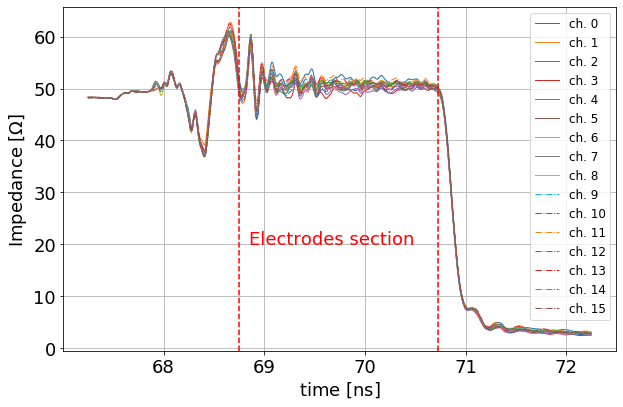

In [96]:
def get_impedance(ch):

    ifile = output+'tdr.txt'
    data = np.loadtxt(ifile,delimiter=', ')

    resistance =[]
    time = []
    for i in range(data.shape[1]):
        resistance.append(data[1+ch][i])
        time.append(data[0][i]*1e9)

    return time,resistance

def plot_impedance():
    plt.figure(figsize=(9,6))
    plt.rcParams["font.size"] = 18
    a = '-'
    for ch in range(16):
        time,res = get_impedance(ch)
        if ch == 9:
            a = '-.'
        plt.plot(time,res,label='ch. '+str(ch),ls=a,lw=1)
        #print(np.min(res))
    plt.grid()
    plt.xlabel('time [$\mathrm{n}$s]')
    plt.ylabel('Impedance [$\mathrm{\Omega}$]')
    plt.tight_layout()
    plt.legend(fontsize=12)
    x = 68.75
    plt.axvline(x, ls = "--", color = "red")
    plt.axvline(x+1.98, ls = "--", color = "red")
    plt.text(x+0.1,20,r'Electrodes section',color='red')
    plt.savefig('imp.pdf')
plot_impedance()

In [97]:
def get_impedance(ch):

    ifile = output+'tdr.txt'
    data = np.loadtxt(ifile,delimiter=', ')

    resistance =[]

    for i in range(data.shape[1]):
        if data[0][i] >6.878e-08 and data[0][i] < 7.070e-08:
            resistance.append(data[1+ch][i])

    num = len(resistance)
    ave = mean(resistance)
    ave_e = stdev(resistance)#/sqrt(num)
    return ave,ave_e

def write_impedance():

    imp = np.empty((2,16))
    for ch in range(16):
        imp[0][ch],imp[1][ch] = get_impedance(ch)
    np.savetxt(output+'impedance.txt',imp,delimiter=', ')
    return imp
write_impedance()

array([[51.67962396, 50.81274325, 50.55940057, 50.06331666, 49.93724351,
        50.54318952, 50.7697449 , 50.82438645, 51.23280656, 51.05570591,
        50.58460066, 51.45882283, 51.07150462, 51.14549141, 50.71104644,
        50.87631031],
       [ 1.57674971,  1.50314887,  1.48589119,  1.6920647 ,  1.66273749,
         1.55804738,  1.48194966,  1.44795389,  1.53169744,  1.51293498,
         1.55615588,  1.4985831 ,  1.55294801,  1.48747813,  1.59033237,
         1.49238379]])

In [98]:
def write_mat():
    par_name=['1700','3400','5100']
    fre = [1,3,5]
    for fre_num in range(3):
        A,eA,inv_A = get_matrix(16,1+2*fre_num)
        ofile = output+'A_'+ par_name[fre_num] +'kHz.txt'
        np.savetxt(ofile,A,delimiter=', ')
        ofile = output+'eA_'+ par_name[fre_num] +'kHz.txt'
        np.savetxt(ofile,eA,delimiter=', ')
        ofile = output+'inv_A_'+ par_name[fre_num] +'kHz.txt'
        np.savetxt(ofile,inv_A,delimiter=', ')
write_mat()
def write_mat_8(j):
    par_name=['1700','3400','5100']
    for fre_num in range(3):
        A,eA,inv_A = get_matrix(8,3,ch=range(j,16,2))
        ofile = output+'A_8pu_'+str(j)+'_'+ par_name[fre_num] +'kHz.txt'
        np.savetxt(ofile,A,delimiter=', ')
        ofile = output+'/eA_8pu_'+str(j)+'_'+ par_name[fre_num] +'kHz.txt'
        np.savetxt(ofile,eA,delimiter=', ')
        ofile = output+'/inv_A_8pu_'+str(j)+'_'+ par_name[fre_num] +'kHz.txt'
        np.savetxt(ofile,inv_A,delimiter=', ')
write_mat_8(0)
write_mat_8(1)

KeyboardInterrupt: 

In [ ]:
num = 60
radius = np.linspace(81,86,num)
result = np.linspace(80,90,num)
chi = np.linspace(80,90,num)
for i in range(num):
    par,epar,chi[i] = get_par(1,3,16,radius[i])
    #result[i] = abs(par[3]/epar[3])
    #result[i] = np.sum(epar**2)
#plt.plot(radius,result)
plt.plot(radius,chi)